# SageMaker DeepAR

<a href='https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html'>Amazon SageMaker DeepAR</a> is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks (RNN). Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit one model to each individual time series, and then use that model to extrapolate the time series into the future. In many applications, however, you might have many similar time series across a set of cross-sectional units (for example, demand for different products, load of servers, requests for web pages, and so on). In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR takes this approach, training a model for predicting a time series over a large set of (related) time series.

Technical details can be found in this <a href='https://arxiv.org/pdf/1704.04110.pdf'>arXiv paper</a>.

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-temperature.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,282.75,284.44,287.37,283.15,291.65,290.82,296.72,297.87,291.35,283.54,298.31,297.59,296.60,289.66,277.90,295.29,283.94,294.67,293.20,294.48,291.20,293.32,290.43,296.15,293.03,280.57,284.09,283.98,272.76,279.11,280.356,285.15,284.706,291.056,291.056,285.15
2017-03-25 02:00:00,282.18,283.30,287.21,282.15,290.89,290.15,296.13,297.00,289.14,281.72,295.89,295.53,296.88,288.65,277.42,294.29,279.83,293.67,292.44,293.75,287.14,293.35,288.88,296.04,292.54,279.42,283.17,282.70,272.47,279.34,279.539,285.15,290.150,291.039,291.039,285.15
2017-03-25 03:00:00,281.50,282.58,286.75,281.77,289.29,289.43,294.72,296.32,288.15,279.15,290.44,294.95,295.97,288.17,277.02,293.58,279.57,293.41,291.91,292.84,284.62,292.32,287.32,295.82,291.74,277.86,281.89,282.67,272.46,279.80,279.539,285.15,283.489,291.039,291.039,285.15
2017-03-25 04:00:00,280.83,282.15,286.52,281.26,288.48,288.33,293.52,294.48,286.55,277.30,288.30,294.28,294.79,287.80,276.82,293.17,279.06,292.65,291.88,292.35,280.70,292.34,286.67,295.65,291.02,277.33,281.24,281.60,272.15,279.90,279.539,285.71,288.150,286.150,286.150,285.76
2017-03-25 05:00:00,280.17,282.15,286.07,280.93,287.91,287.60,293.34,292.02,285.56,276.30,287.57,293.42,293.87,287.30,276.68,292.46,278.77,291.65,290.56,291.59,280.56,291.35,286.88,295.87,290.16,276.88,280.38,281.01,272.15,279.74,285.676,285.71,288.150,285.150,285.150,285.76


## Define Parameters

Make predictions for 24-hour period based on the previous four weeks' worth of data. DeepAR will be trained across the whole dataset (excluding the 24-hour test period).

In [4]:
dataset_name = 'Hourly Weather Temperature'
dataset_abbr = 'HWT'
model_name = 'DeepAR'
context_length = 24*7*4 # Four weeks
prediction_length = 24
freq = pd.infer_freq(df.index)

## Configure S3 Storage and Container

In [5]:
bucket = '<your_bucket_name_here>'
prefix = 'sagemaker/deepar/%s' % dataset_abbr

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, the container image is configured to be use the appropriate region.

In [6]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-1': '633353088612.dkr.ecr.ap-northeast-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-2': '204372634319.dkr.ecr.ap-northeast-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [7]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Prepare Data for SageMaker

Extract time series and set aside data for testing.

In [8]:
time_series = []
for k in df.columns:
    time_series.append(df[k])
    
time_series_training = []
for ts in df.columns:
    time_series_training.append(df.iloc[:-prediction_length][ts])

Visualise time series example.

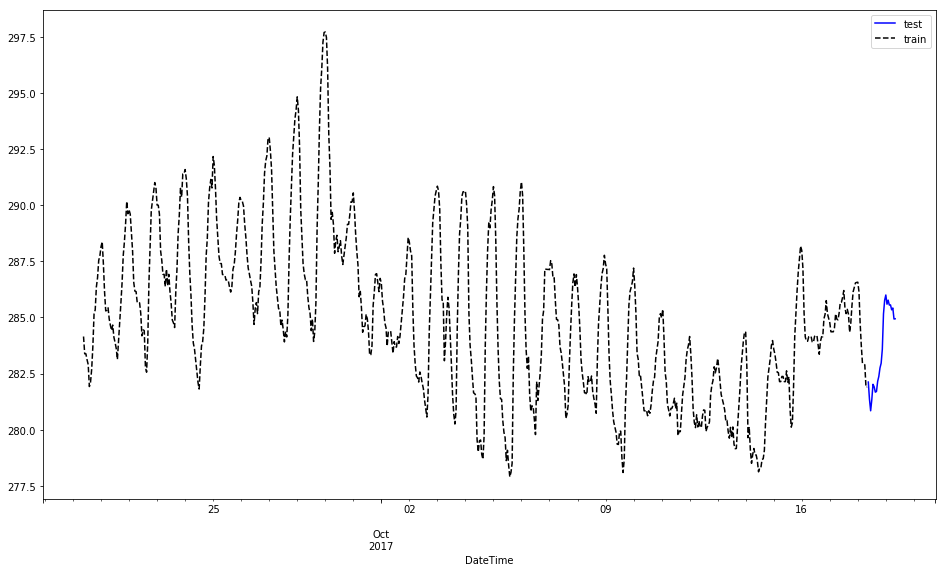

In [9]:
time_series[0][-prediction_length:].plot(label='test', figsize=(16, 9), c='b')
time_series_training[0][-context_length:].plot(label='train', c='k', linestyle='--')
plt.legend()
plt.show()

Convert time series into JSON strings for DeepAR.

In [10]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [11]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

## Train Model

Define the estimator for training and set hyperparameters.

In [12]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.8xlarge',
    base_job_name='%s-deepar' % dataset_abbr,
    output_path="s3://" + s3_output_path
)

In [13]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [14]:
estimator.set_hyperparameters(**hyperparameters)

Launch training job.

In [15]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: HWT-deepar-2018-10-13-18-58-43-630


2018-10-13 18:58:43 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training......
2018-10-13 19:00:55 Downloading - Downloading input data
2018-10-13 19:01:02 Training - Downloading the training image...
Training image download completed. Training in progress..
Arguments: train
[10/13/2018 19:01:43 INFO 140137778718528] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/13/2018 19:01:43 INFO 14013777

[10/13/2018 19:03:49 INFO 140137778718528] Epoch[2] Batch[5] avg_epoch_loss=3.958045
[10/13/2018 19:03:49 INFO 140137778718528] Epoch[2] Batch [5]#011Speed: 22.11 samples/sec#011loss=3.958045
[10/13/2018 19:03:56 INFO 140137778718528] Epoch[2] Batch[10] avg_epoch_loss=3.862638
[10/13/2018 19:03:56 INFO 140137778718528] Epoch[2] Batch [10]#011Speed: 22.10 samples/sec#011loss=3.748149
[10/13/2018 19:03:56 INFO 140137778718528] processed a total of 347 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 16188.424110412598, "sum": 16188.424110412598, "min": 16188.424110412598}}, "EndTime": 1539457436.915277, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1539457420.726807}

[10/13/2018 19:03:56 INFO 140137778718528] #throughput_metric: host=algo-1, train throughput=21.4349466349 records/second
[10/13/2018 19:03:56 INFO 140137778718528] #progress_metric: host=algo-1, completed 15 % of epochs
[10/13/2018 19:03:56 INFO 14013777

[10/13/2018 19:05:25 INFO 140137778718528] Epoch[8] Batch[5] avg_epoch_loss=2.953411
[10/13/2018 19:05:25 INFO 140137778718528] Epoch[8] Batch [5]#011Speed: 22.15 samples/sec#011loss=2.953411
[10/13/2018 19:05:31 INFO 140137778718528] processed a total of 312 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 14688.601970672607, "sum": 14688.601970672607, "min": 14688.601970672607}}, "EndTime": 1539457531.329298, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1539457516.640644}

[10/13/2018 19:05:31 INFO 140137778718528] #throughput_metric: host=algo-1, train throughput=21.2407816276 records/second
[10/13/2018 19:05:31 INFO 140137778718528] #progress_metric: host=algo-1, completed 45 % of epochs
[10/13/2018 19:05:31 INFO 140137778718528] best epoch loss so far
[10/13/2018 19:05:31 INFO 140137778718528] Saved checkpoint to "/opt/ml/model/state_1d3fe7a3-57f4-4376-b51b-a5073c9b0f5b-0000.params"
#metrics {"Metrics": {"state

[10/13/2018 19:07:13 INFO 140137778718528] Epoch[15] Batch[5] avg_epoch_loss=2.792057
[10/13/2018 19:07:13 INFO 140137778718528] Epoch[15] Batch [5]#011Speed: 22.27 samples/sec#011loss=2.792057
[10/13/2018 19:07:19 INFO 140137778718528] processed a total of 311 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 14626.435995101929, "sum": 14626.435995101929, "min": 14626.435995101929}}, "EndTime": 1539457639.458739, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1539457624.832259}

[10/13/2018 19:07:19 INFO 140137778718528] #throughput_metric: host=algo-1, train throughput=21.2627284491 records/second
[10/13/2018 19:07:19 INFO 140137778718528] #progress_metric: host=algo-1, completed 80 % of epochs
[10/13/2018 19:07:19 INFO 140137778718528] loss did not improve for 1 epochs
[10/13/2018 19:07:21 INFO 140137778718528] Epoch[16] Batch[0] avg_epoch_loss=2.715904
[10/13/2018 19:07:28 INFO 140137778718528] Epoch[16] Batch[5] a

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 2799.97181892395, "sum": 2799.97181892395, "min": 2799.97181892395}}, "EndTime": 1539457785.404639, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1539457782.604739}

[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, RMSE): 4.93108521006
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, mean_wQuantileLoss): 0.0105365
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, wQuantileLoss[0.1]): 0.00701526
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, wQuantileLoss[0.2]): 0.0102263
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, wQuantileLoss[0.3]): 0.0121296
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, wQuantileLoss[0.4]): 0.0131386
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1, wQuantileLoss[0.5]): 0.0133326
[10/13/2018 19:09:45 INFO 140137778718528] #test_score (algo-1,

## Create Endpoint and Predictor

In [16]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: HWT-deepar-2018-10-13-18-58-43-630
INFO:sagemaker:Creating endpoint-config with name HWT-deepar-2018-10-13-18-58-43-630
INFO:sagemaker:Creating endpoint with name HWT-deepar-2018-10-13-18-58-43-630


--------------------------------------------------------------!

Create utility class to make predictions from Pandas Series.

In [17]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [(x.index[-1].to_period(self.freq)+1).to_timestamp() for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [18]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make Predictions

In [19]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series

In [20]:
tic = time.time()
for i in range(5, len(time_series), 5):
    toc = time.time()
    print("Running predictions for time series {} to {}... (cumulative time: {:.1f}s.)".format(
        i+1, min(i+5, len(time_series))+1, toc-tic))
    pred = predictor.predict(time_series_training[i:(i+5)])
    list_of_df = list_of_df + pred

Running predictions for time series 6 to 11... (cumulative time: 0.0s.)
Running predictions for time series 11 to 16... (cumulative time: 1.1s.)
Running predictions for time series 16 to 21... (cumulative time: 2.1s.)
Running predictions for time series 21 to 26... (cumulative time: 3.0s.)
Running predictions for time series 26 to 31... (cumulative time: 3.8s.)
Running predictions for time series 31 to 36... (cumulative time: 4.7s.)
Running predictions for time series 36 to 37... (cumulative time: 5.5s.)


Show some example forecasts.

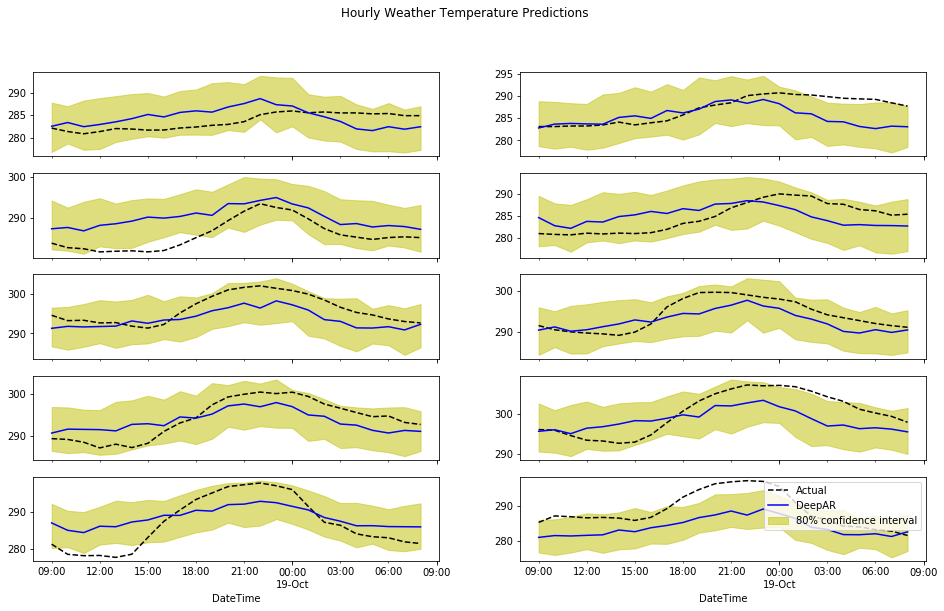

In [21]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for k in range(10):
    actual_data[k][-prediction_length:].plot(label='Actual', c='k',
                                             linestyle='--', ax=ax[k])
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    ax[k].fill_between(p10.index, p10, p90, color='y', alpha=0.5,
                         label='80% confidence interval')
    list_of_df[k]['0.5'][-prediction_length:].plot(label='DeepAR', c='b', ax=ax[k])
ax[9].legend()
fig.suptitle('{} Predictions'.format(dataset_name))
plt.show()

## Evaluate DeepAR

In [22]:
results = df.copy()
for i in range(len(results.columns)):
    results['pred%s' % (i+1)] = 0
    results['pred%s' % (i+1)].iloc[-prediction_length:] = list_of_df[i]['0.5'].values

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Power must be positive, so setting any negative values equal to zero will improve the accuracy of the model.

In [23]:
results0 = results.copy()
results0[results0 < 0] = 0
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,282.75,284.44,287.37,283.15,291.65,290.82,296.72,297.87,291.35,283.54,298.31,297.59,296.60,289.66,277.90,295.29,283.94,294.67,293.20,294.48,291.20,293.32,290.43,296.15,293.03,280.57,284.09,283.98,272.76,279.11,280.356,285.15,284.706,291.056,291.056,285.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-25 02:00:00,282.18,283.30,287.21,282.15,290.89,290.15,296.13,297.00,289.14,281.72,295.89,295.53,296.88,288.65,277.42,294.29,279.83,293.67,292.44,293.75,287.14,293.35,288.88,296.04,292.54,279.42,283.17,282.70,272.47,279.34,279.539,285.15,290.150,291.039,291.039,285.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-25 03:00:00,281.50,282.58,286.75,281.77,289.29,289.43,294.72,296.32,288.15,279.15,290.44,294.95,295.97,288.17,277.02,293.58,279.57,293.41,291.91,292.84,284.62,292.32,287.32,295.82,291.74,277.86,281.89,282.67,272.46,279.80,279.539,285.15,283.489,291.039,291.039,285.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-25 04:00:00,280.83,282.15,286.52,281.26,288.48,288.33,293.52,294.48,286.55,277.30,288.30,294.28,294.79,287.80,276.82,293.17,279.06,292.65,291.88,292.35,280.70,292.34,286.67,295.65,291.02,277.33,281.24,281.60,272.15,279.90,279.539,285.71,288.150,286.150,286.150,285.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-25 05:00:00,280.17,282.15,286.07,280.93,287.91,287.60,293.34,292.02,285.56,276.30,287.57,293.42,293.87,287.30,276.68,292.46,278.77,291.65,290.56,291.59,280.56,291.35,286.88,295.87,290.16,276.88,280.38,281.01,272.15,279.74,285.676,285.71,288.150,285.150,285.150,285.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length+prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

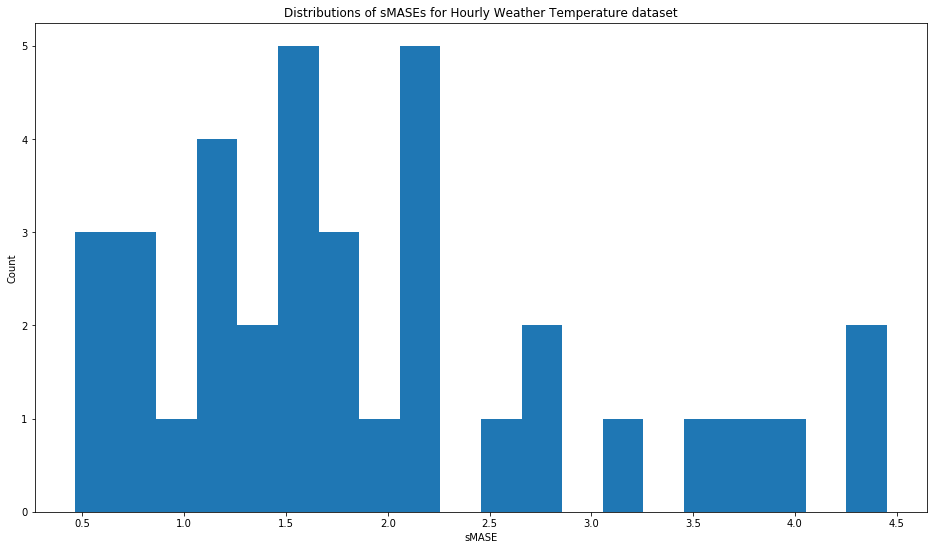

In [25]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [26]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 1.9289


Store the predictions and accuracy score for the DeepAR model.

In [28]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)

## Delete Endpoint

In [29]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: HWT-deepar-2018-10-13-18-58-43-630
